In [170]:
import uproot
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [175]:
metrics = pd.read_csv('metrics.csv')
metrics.columns = ['index2', 'set', 'designator', 'err', 'res', 'rms']
metrics = metrics.drop(columns='index2')
metrics['set'] = metrics['set'].astype('int').add(1)
metrics

,set,designator,err,res,rms
0,1,err,0.157851,0.593892,1.081380
1,1,res,0.017053,0.071878,0.113827
2,1,rms,0.014291,0.051366,0.095300
3,1,final,0.009499,0.066132,0.084716
4,2,err,0.075774,0.191013,0.711684
...,...,...,...,...,...
175,44,final,0.005887,0.014061,0.097453
176,45,err,0.085328,0.366315,1.028659
177,45,res,0.022023,0.048990,0.191585
178,45,rms,0.016602,0.027761,0.127935


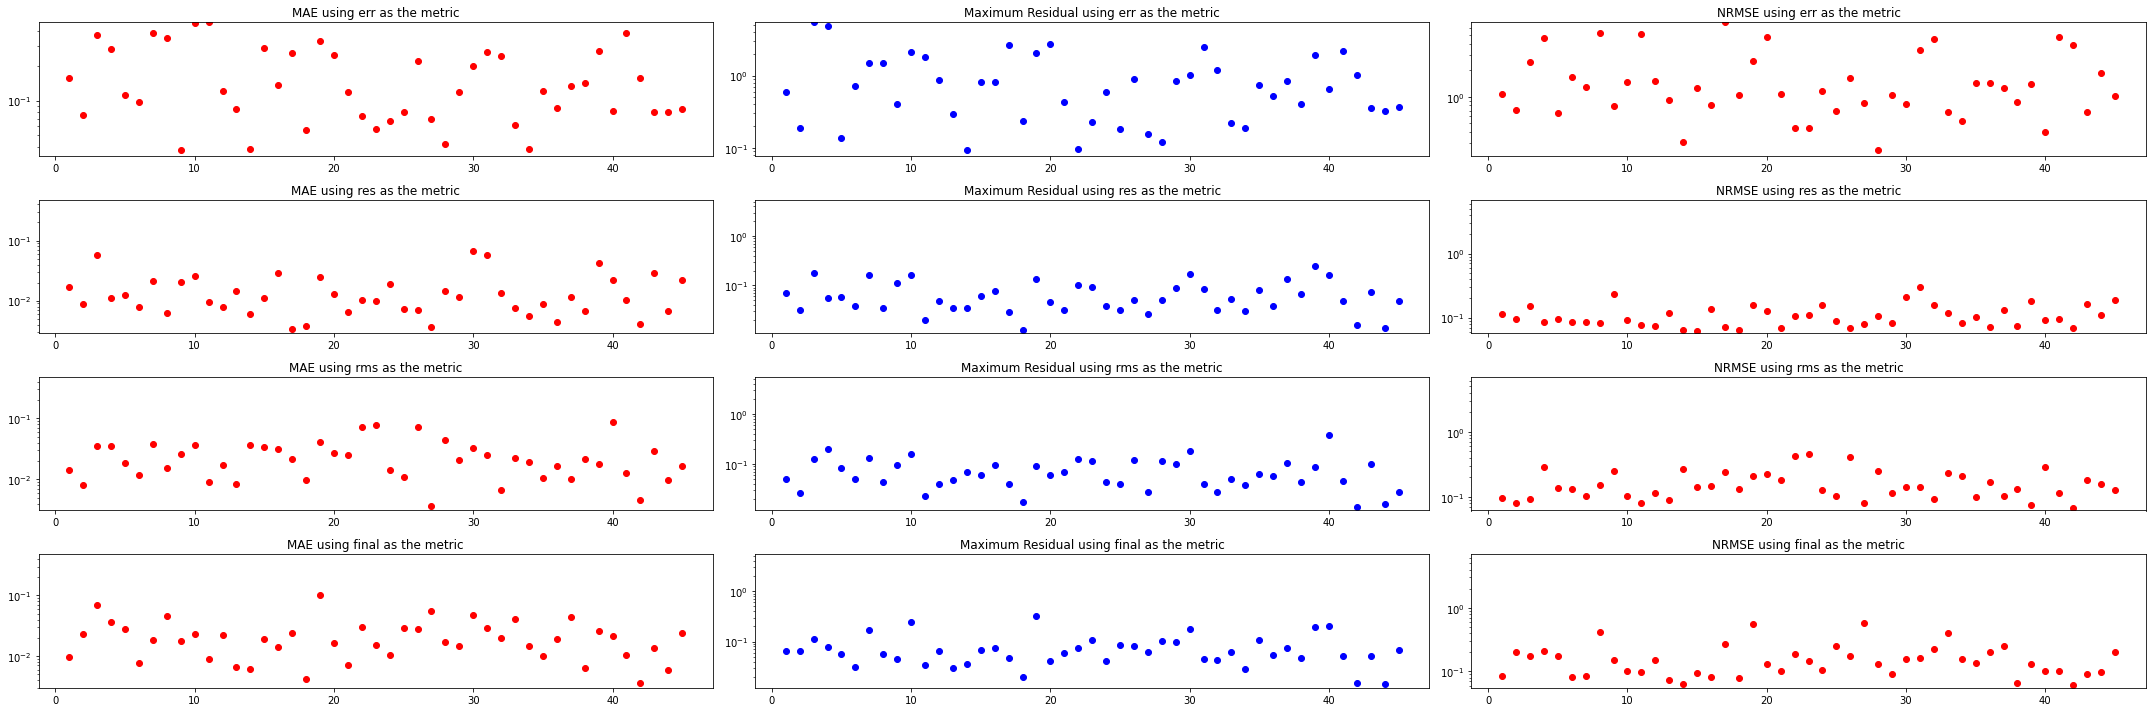

In [176]:
fig, ax = plt.subplots(4,3, figsize=(30,10));

errList = resList = rmsList = overallList = []

mappings = {'err':0,'res':1,'rms':2,'final':3}

for index,row in metrics.iterrows():
    
    ax[ mappings[ row['designator'] ] ][0].scatter(row['set'], row['err'], c='r')
    ax[ mappings[ row['designator'] ] ][0].set_title('MAE using ' + row['designator'] + ' as the metric')
    ax[ mappings[ row['designator'] ] ][0].set_yscale('log')
    
    ax[ mappings[ row['designator'] ] ][1].scatter(row['set'], row['res'], c='b')
    ax[ mappings[ row['designator'] ] ][1].set_title('Maximum Residual using ' + row['designator'] + ' as the metric')
    ax[ mappings[ row['designator'] ] ][1].set_yscale('log')
    
    ax[ mappings[ row['designator'] ] ][2].scatter(row['set'], row['rms'], c='r')
    ax[ mappings[ row['designator'] ] ][2].set_title('NRMSE using ' + row['designator'] + ' as the metric')
    ax[ mappings[ row['designator'] ] ][2].set_yscale('log')
    
for i in ax:
    i[0].set_ylim(top=metrics['err'].max())
    i[1].set_ylim(top=metrics['res'].max())
    i[2].set_ylim(top=metrics['rms'].max())
    
plt.tight_layout();

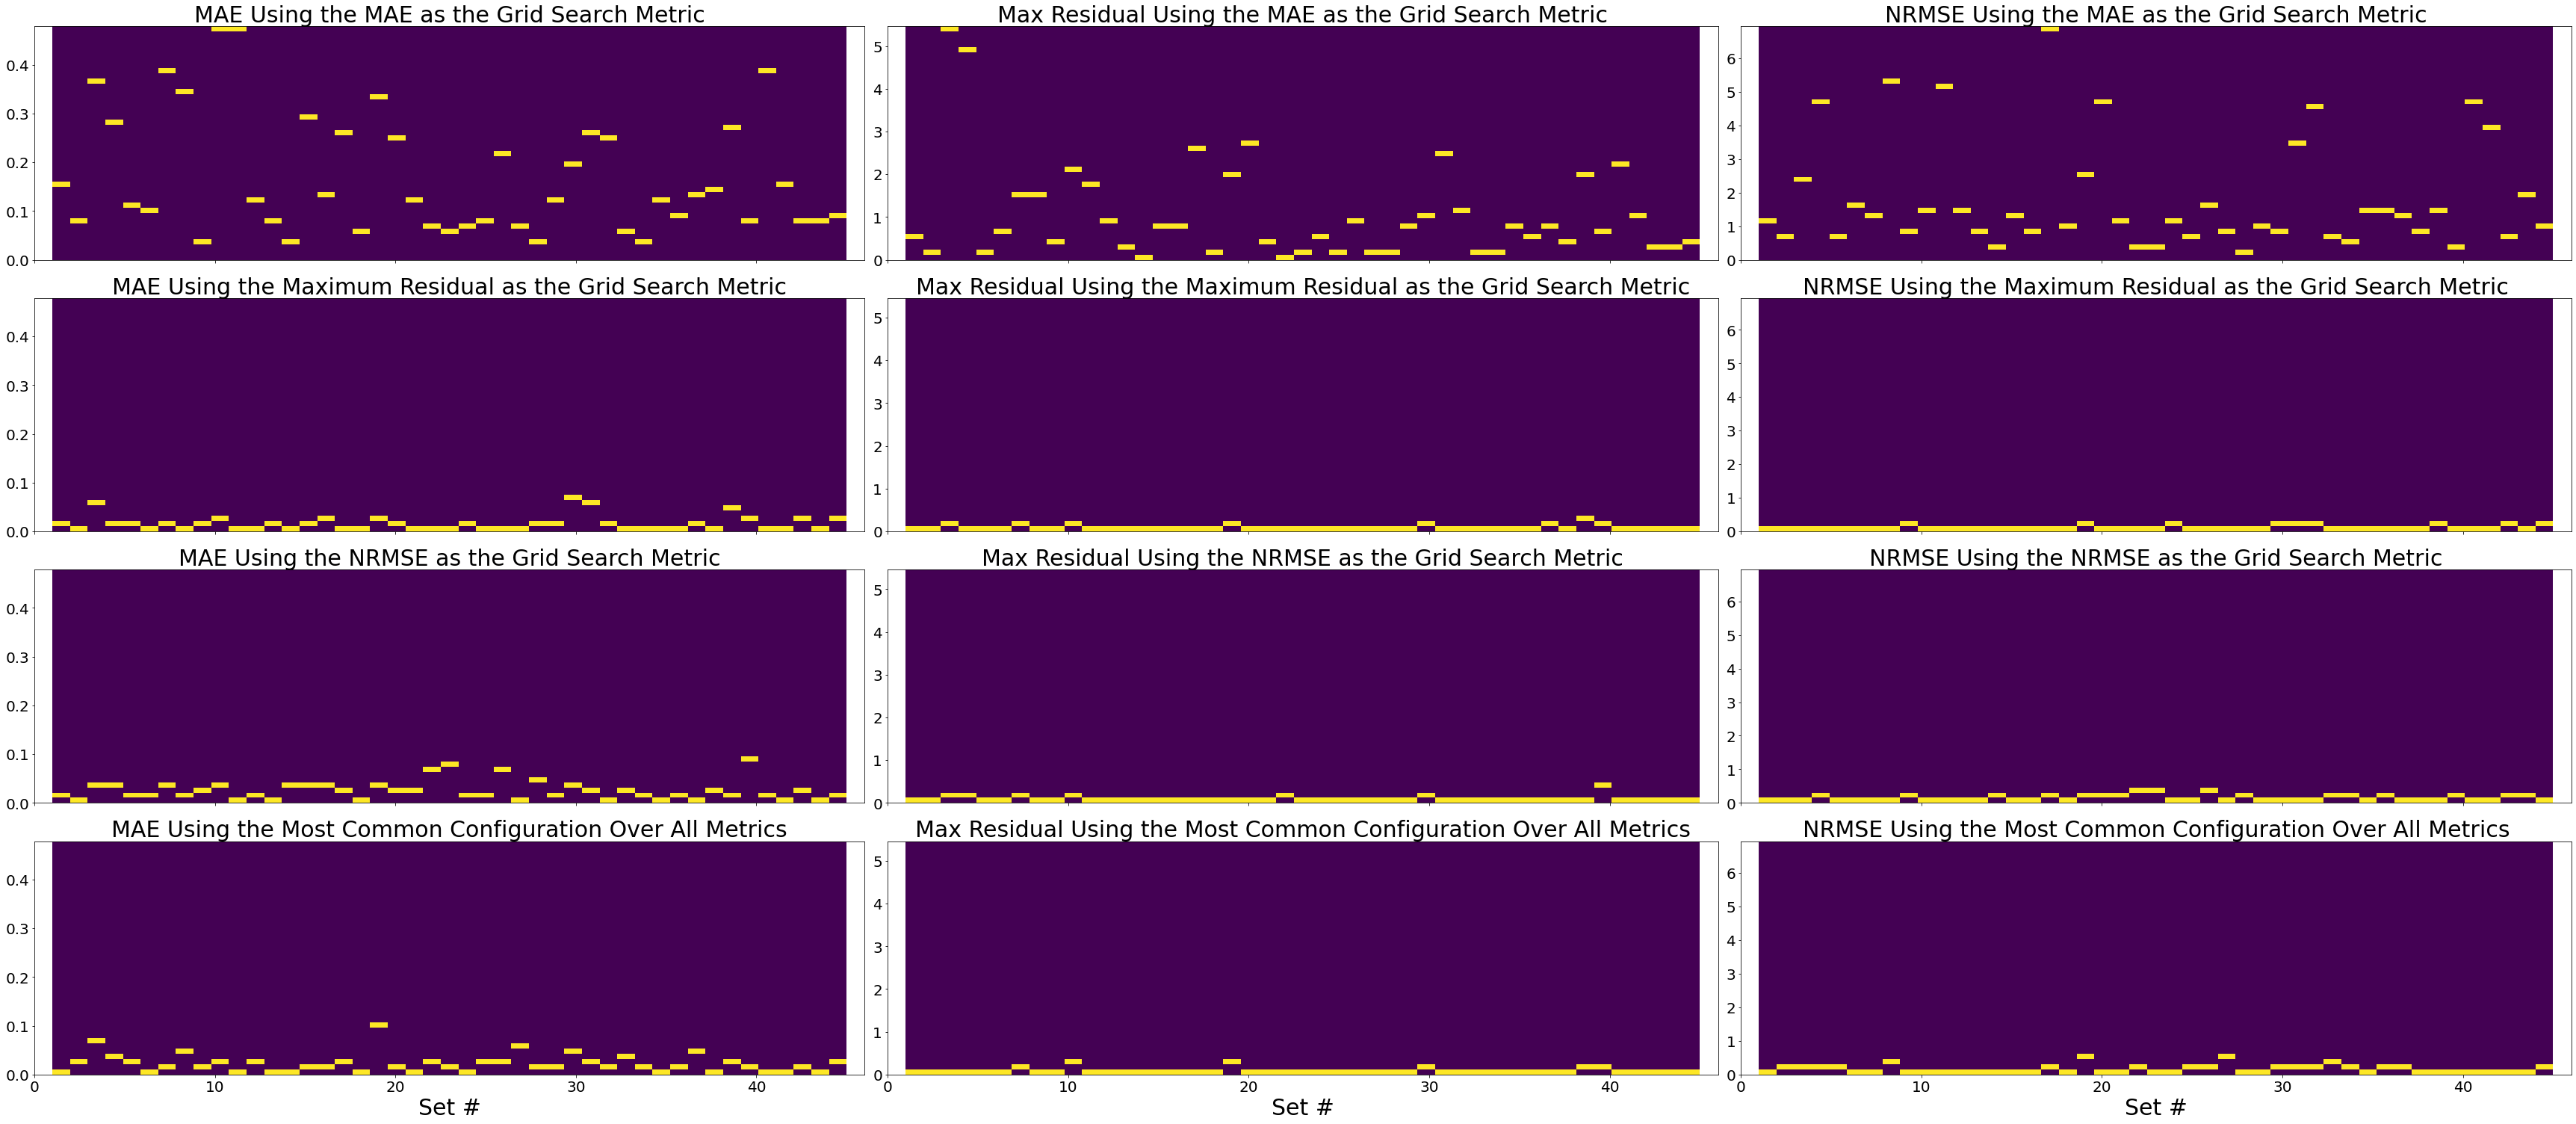

In [177]:
boundaryColors = ['cyan', 'lime', 'yellow', 'pink']
fig, axs = plt.subplots(4,3, figsize=(12*4,7*3), sharex=True);
row = 0

for n,metric in enumerate(metrics.columns[2:]):
    for j,designator in enumerate(mappings.keys()):
        df_masked = metrics[metrics.designator == designator];
        
        histo = axs[j][n].hist2d(df_masked.set,
                                 df_masked[metric], 
                                 range=((1, 45),(0, metrics[metric].max())), 
                                 bins=45);
#         fig.colorbar(histo[3], ax=axs[j][n]);
        
        axs[j][n].set_ylim(top=metrics[metric].max(), bottom=0);
        axs[j][n].set_xlim(left=0, right=46);
        title = ""
        ylabel = ""
        if metric == 'err':
            title += "MAE Using "
            ylabel = "MAE"
        elif metric == 'res':
            title += "Max Residual Using "
            ylabel = "Max Residual"
        elif metric == 'rms':
            title += "NRMSE Using "
            ylabel = "NRMSE"
        
        if designator == 'err':
            title += "the MAE as the Grid Search Metric"
        elif designator == 'res':
            title += "the Maximum Residual as the Grid Search Metric"
        elif designator == 'rms':
            title += "the NRMSE as the Grid Search Metric"
        else:
            title += "the Most Common Configuration Over All Metrics"
            
        axs[j][n].set_title(title, fontsize=30);
        axs[j][n].tick_params(axis='both', labelsize=20);
#         axs[j][n].set_ylabel(ylabel, fontsize=30);
        if j == 3:
            axs[j][n].set_xlabel("Set #", fontsize=30);
fig.tight_layout()

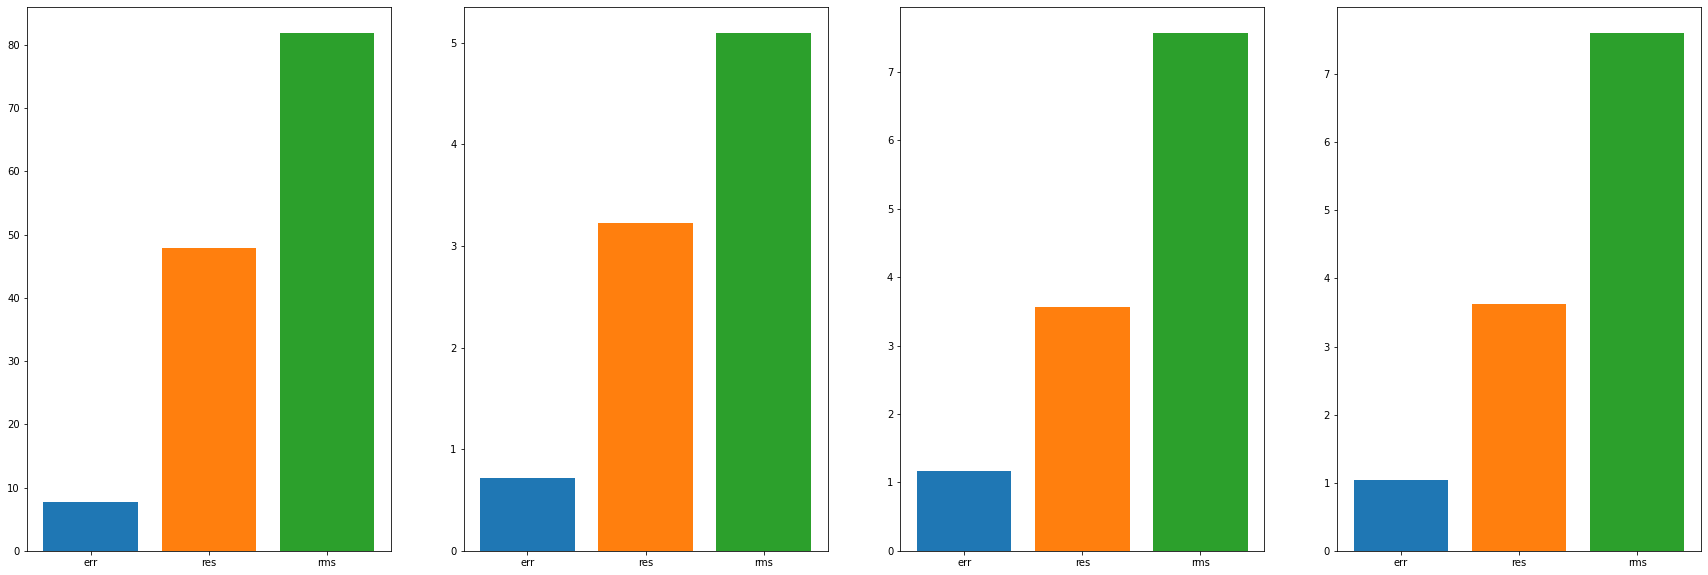

In [178]:
fig, ax = plt.subplots(1,4, figsize=(30,10));
for x_axis_element in metrics.columns[2:]:
    for n,designator in enumerate(mappings.keys()):
        ax[n].bar(x_axis_element, np.sum(metrics[metrics.designator == designator][x_axis_element]));

In [179]:
MAE_combinations = pd.read_csv('best_combination_errors.csv', names=['Set#', '#epochs', "batch#", "metric_value"])
MAE_combinations
MAE_combinations['metric'] = 'MAE'
RES_combinations = pd.read_csv('best_combination_residual.csv', names=['Set#', '#epochs', "batch#", "metric_value"])
RES_combinations['metric'] = 'RES'
NRMSE_combinations= pd.read_csv('best_combination_rms.csv', names=['Set#', '#epochs', "batch#", "metric_value"])
NRMSE_combinations['metric'] = 'NRMSE'

best_combos = pd.concat([MAE_combinations, RES_combinations, NRMSE_combinations]).dropna()
best_combos[['Set#','#epochs','batch#']] = best_combos[['Set#','#epochs','batch#']].astype(int)
best_combos

,Set#,#epochs,batch#,metric_value,metric
1,0,9900,1,0.008561250486662118,MAE
2,20,14500,1,0.005119042095106653,MAE
3,40,2300,6,0.00504391858110322,MAE
4,60,11300,46,0.006276372055391736,MAE
5,80,10400,21,0.008943929344609578,MAE
6,100,6300,6,0.0005974017190212008,MAE
7,120,7700,46,0.0020411849778730878,MAE
8,140,11900,11,0.0026805015388488783,MAE
9,160,4000,41,0.0010270608021973238,MAE
10,180,9900,1,0.00026678053585977034,MAE


In [180]:
best_combos.query('metric=="MAE"')

,Set#,#epochs,batch#,metric_value,metric
1,0,9900,1,0.008561250486662118,MAE
2,20,14500,1,0.005119042095106653,MAE
3,40,2300,6,0.00504391858110322,MAE
4,60,11300,46,0.006276372055391736,MAE
5,80,10400,21,0.008943929344609578,MAE
6,100,6300,6,0.0005974017190212008,MAE
7,120,7700,46,0.0020411849778730878,MAE
8,140,11900,11,0.0026805015388488783,MAE
9,160,4000,41,0.0010270608021973238,MAE
10,180,9900,1,0.00026678053585977034,MAE


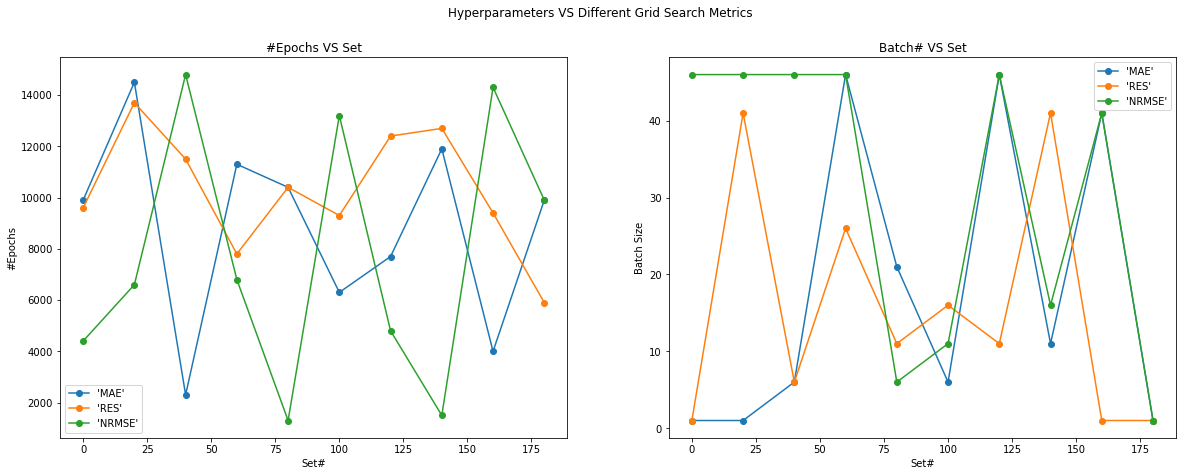

In [182]:
metricsList = ["'MAE'", "'RES'", "'NRMSE'"]
fig, ax = plt.subplots(1,2,figsize=(20,7))
for metric in metricsList:
    intermediate_df = best_combos.query('metric=='+metric)
    ax[0].plot(intermediate_df['Set#'], intermediate_df['#epochs'], marker='o', label=metric)
    ax[1].plot(intermediate_df['Set#'], intermediate_df['batch#'], marker='o', label=metric)

ax[0].set_title('#Epochs VS Set');
ax[0].set_xlabel('Set#');
ax[0].set_ylabel('#Epochs');
# ax[0].set_xticks([0,1,2,3,4], fontsize=20);

ax[1].set_title('Batch# VS Set');
ax[1].set_xlabel('Set#');
ax[1].set_ylabel('Batch Size');
# ax[1].set_xticks([0,1,2,3,4], fontsize=20);

fig.suptitle('Hyperparameters VS Different Grid Search Metrics');


ax[0].legend();
ax[1].legend();